# Bridging Pixels and Patterns using Fully Connected Neural Networks

**Question 2**

## Goal
The objective of this experiment is to understand how Fully Connected Neural Networks (FCNNs)
learn patterns from raw pixel values and to analyze their limitations with respect to spatial
awareness.

We perform two experiments:
1. **Weight Visualization** on normal MNIST
2. **Flattening (Pixel Scrambling) Experiment**

The experiments are implemented using **PyTorch**.


## 1. Imports and Environment Setup

We begin by importing the necessary libraries for:
- Deep learning (PyTorch)
- Data handling (NumPy, Pandas)
- Visualization (Matplotlib)




In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## 2. Hyperparameters

We define the training hyperparameters used consistently across experiments.

## 3. MNIST CSV Dataset

The MNIST dataset is provided in CSV format:
- First column: digit label (0–9)
- Remaining 784 columns: pixel intensities

The images are normalized to the range **[-1, 1]** for stable training.


In [3]:
BATCH_SIZE = 64
EPOCHS = 5
LR = 0.001


In [ ]:
class MNISTCSV(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.labels = df.iloc[:, 0].values
        self.images = df.iloc[:, 1:].values.astype(np.float32)

        
        self.images = (self.images / 255.0 - 0.5) / 0.5

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x = torch.tensor(self.images[idx])
        y = torch.tensor(self.labels[idx]).long()
        return x, y


## 4. Data Loading

We load the training and testing datasets and create PyTorch DataLoaders.


In [4]:
train_dataset = MNISTCSV("mnist_train.csv")
test_dataset = MNISTCSV("mnist_test.csv")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## 5. Fully Connected Neural Network (FCNN)

Architecture:
- Input layer: 784 neurons (flattened pixels)
- Hidden Layer 1: 128 neurons
- Hidden Layer 2: 64 neurons
- Output Layer: 10 neurons (digit classes)





In [6]:
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


## 6. Training and Evaluation Functions


- **Training** uses Adam optimizer and Cross-Entropy loss
- **Evaluation** computes classification accuracy


In [9]:
def train(model, loader):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {total_loss:.4f}")

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


## 7. Question 2.1 — Training on Normal MNIST

The FCNN is trained on the original MNIST dataset.
We then visualize the learned weights of the **first hidden layer**.


In [10]:
print("\nTraining FCNN on NORMAL MNIST (CSV)")
model_normal = FCNN().to(device)
train(model_normal, train_loader)

normal_acc = evaluate(model_normal, test_loader)
print(f"Normal MNIST Accuracy: {normal_acc:.4f}")



Training FCNN on NORMAL MNIST (CSV)
Epoch [1/5] Loss: 373.1346
Epoch [2/5] Loss: 178.1537
Epoch [3/5] Loss: 127.5849
Epoch [4/5] Loss: 101.1038
Epoch [5/5] Loss: 85.8235
Normal MNIST Accuracy: 0.9710


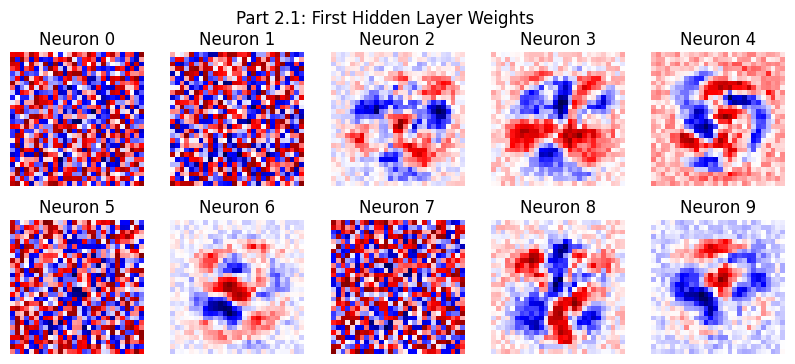

In [11]:
weights = model_normal.fc1.weight.data.cpu().numpy()

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(weights[i].reshape(28, 28), cmap="seismic")
    plt.axis("off")
    plt.title(f"Neuron {i}")

plt.suptitle("Part 2.1: First Hidden Layer Weights")
plt.show()


### Observation (Weight Visualization)

The visualized weights resemble:
- Stroke-like patterns
- Lines and curves
- Partial digit components

The first-layer neurons learn stroke-like and edge-based pixel patterns rather than complete digits. Some neurons appear noisy, reflecting weak or distributed pixel correlations. This indicates that FCNNs learn statistical pixel relationships rather than structured visual features.


## 8. Question 2.2 — Flattening (Pixel Scrambling) Experiment

All images are scrambled using the **same random permutation** of pixels.
Spatial structure is destroyed, but pixel statistics remain unchanged.


In [12]:
perm = torch.randperm(784)

class ScrambledMNISTCSV(Dataset):
    def __init__(self, base_dataset, perm):
        self.base_dataset = base_dataset
        self.perm = perm

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, y = self.base_dataset[idx]
        x = x[self.perm]
        return x, y


In [13]:
scrambled_train = ScrambledMNISTCSV(train_dataset, perm)
scrambled_test = ScrambledMNISTCSV(test_dataset, perm)

scrambled_train_loader = DataLoader(scrambled_train, batch_size=BATCH_SIZE, shuffle=True)
scrambled_test_loader = DataLoader(scrambled_test, batch_size=BATCH_SIZE, shuffle=False)

print("\nTraining FCNN on SCRAMBLED MNIST (CSV)")
model_scrambled = FCNN().to(device)
train(model_scrambled, scrambled_train_loader)

scrambled_acc = evaluate(model_scrambled, scrambled_test_loader)
print(f"Scrambled MNIST Accuracy: {scrambled_acc:.4f}")



Training FCNN on SCRAMBLED MNIST (CSV)
Epoch [1/5] Loss: 370.8019
Epoch [2/5] Loss: 171.8415
Epoch [3/5] Loss: 124.9747
Epoch [4/5] Loss: 99.4415
Epoch [5/5] Loss: 86.5547
Scrambled MNIST Accuracy: 0.9714


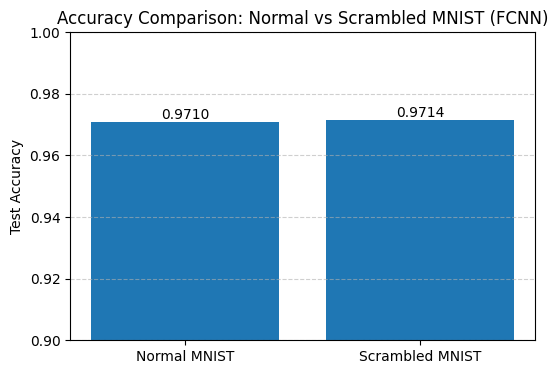

In [15]:


accuracies = [normal_acc, scrambled_acc]
labels = ["Normal MNIST", "Scrambled MNIST"]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, accuracies)


for bar, acc in zip(bars, accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{acc:.4f}",
        ha="center",
        va="bottom"
    )

plt.ylim(0.9, 1.0)
plt.ylabel("Test Accuracy")
plt.title("Accuracy Comparison: Normal vs Scrambled MNIST (FCNN)")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()


## 9. Final Results and Comparison


In [14]:
print("\n========== FINAL COMPARISON ==========")
print(f"Normal MNIST Accuracy    : {normal_acc:.4f}")
print(f"Scrambled MNIST Accuracy : {scrambled_acc:.4f}")



========== FINAL COMPARISON ==========
Normal MNIST Accuracy    : 0.9710
Scrambled MNIST Accuracy : 0.9714


### Observation (Flattening Experiment)

The FCNN achieves nearly identical accuracy on normal and scrambled MNIST because it lacks spatial awareness. Since the same pixel permutation is applied to all images, the network can relearn a consistent mapping from input vectors to labels. Humans fail on scrambled images because human vision depends on spatial relationships, which FCNNs do not model.
